In [129]:
import hist
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from wremnants import boostHistHelpers as hh
from wremnants import histselections as sel
from wremnants import datasets2016
import lz4.frame
import pickle
hep.style.use(hep.style.ROOT)

In [130]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
with lz4.frame.open("../../mw_with_mu_eta_pt.pkl.lz4") as f:
    boost = pickle.load(f)

In [132]:
def readForDataset(output, name, histname="nominal"):
    if name not in output:
        raise ValueError(f"Sample {name} not in file")
    lumi = 1. if not "dataPostVFP" in output else output["dataPostVFP"]["lumi"]*1000
    info = output[name]
    scale = 1. if output[name]["dataset"]["is_data"] else \
                lumi*info["dataset"]["xsec"]/info["weight_sum"]
    print(scale)
    return info["output"][histname]*scale

In [133]:
def unrolledHist(h, obs=["pt", "eta"]):
    bins = np.multiply(*[len(a) for a in h.axes[:2]])
    newh = hist.Hist(hist.axis.Regular(bins, 0, bins), storage=hist.storage.Weight())
    newh[...] = np.ravel(h.project(*obs))
    return newh

In [134]:
def makeVariationPlot(chn, variations, obs, xlabel, rrange=[0.9, 1.1], scale=8.5e6):
    if type(variations) == str: variations = list(variations)
    width=3 if "unrolled" in obs else 1
    fig = plt.figure(figsize=(8*width,8))
    ax1 = fig.add_subplot(4, 1, (1, 3)) 
    ax2 = fig.add_subplot(4, 1, 4) 
    
    op = lambda x: x.project(obs) 
    if obs == "unrolled":
        op = unrolledHist

    hists  = [op(wgen[chn]['hist']['nominal']), *[op(wgen[chn]['hist']['vars'][x]) for x in variations]]
    colors = [wgen[chn]['color']['nominal'], *wgen[chn]['color']['vars']]
    labels = [wgen[chn]['label']['nominal'], *wgen[chn]['label']['vars']]
    
    hep.histplot(
        hists,
        histtype = "step",
        color = colors,
        label = labels,
        ax = ax1
    )
    

    hep.histplot(
        [hh.divideHists(x, hists[0]) for x in hists],
        histtype="step",
        yerr=False,
        color=colors,
        ax=ax2
    )
        
    ax1.set_xlabel("")
    ax2.set_xlabel(xlabel)
    ax1.set_ylabel("Events/bin")
    ax1.set_xticklabels([])
    xrange = [hists[0].axes[0].edges[0], hists[0].axes[0].edges[len(hists[0].axes[0])-1]]
    ax1.set_xlim(xrange)
    ax2.set_xlim(xrange)
    ax2.set_ylabel("variation/nominal", fontsize=22)
    ax2.set_ylim(rrange)
    ax1.set_ylim([0, scale])
    ax1.legend(prop={'size' : 20*(0.7 if width == 1 else 1.3)}, loc='upper right')

In [148]:
boost.keys()
boost['WplusmunuPostVFP']['output']['nominal']

Hist(
  Regular(48, -2.4, 2.4, name='eta', label='eta'),
  Regular(29, 26, 55, name='pt', label='pt'),
  Regular(2, -2, 2, underflow=False, overflow=False, name='charge', label='charge'),
  Boolean(name='passIso', label='passIso'),
  Boolean(name='passMT', label='passMT'),
  Variable([0, 2.9, 4.7, 6.7, 9, 11.8, 15.3, 20.1, 27.2, 40.2, 13000], name='genPtV', label='genPtV'),
  Integer(0, 9, underflow=False, overflow=False, name='tensor_axis_0', label='tensor_axis_0'),
  storage=Weight()) # Sum: WeightedSum(value=9.26394e+08, variance=5.4568e+09) (WeightedSum(value=1.07169e+09, variance=5.76453e+09) with flow)

In [150]:
boost['WplusmunuPostVFP']['output']['pdfNNPDF31']

Hist(
  Regular(48, -2.4, 2.4, name='eta', label='eta'),
  Regular(29, 26, 55, name='pt', label='pt'),
  Regular(2, -2, 2, underflow=False, overflow=False, name='charge', label='charge'),
  Boolean(name='passIso', label='passIso'),
  Boolean(name='passMT', label='passMT'),
  Integer(0, 101, underflow=False, overflow=False, name='tensor_axis_0', label='tensor_axis_0'),
  storage=Weight()) # Sum: WeightedSum(value=1.04696e+10, variance=1.29713e+10) (WeightedSum(value=1.20951e+10, variance=1.48633e+10) with flow)

In [136]:
datagroups = {
    "Data" : dict(
        members = ["dataPostVFP"],
        color = "black",
        label = "Data",
        hist = {},
    ),
    "Fake" : dict(
        members = list(boost.keys()),
        label = "Nonprompt",
        color = "grey",
        hist = {},
    ),
    "Zmumu" : dict(
        members = ["ZmumuPostVFP"],
        label = r"Z$\to\mu\mu$",
        color = "lightblue",
        hist = {},
    ),   
    "Wtau" : dict(
        members = ["WminustaunuPostVFP", "WplustaunuPostVFP"],
        label = r"W$^{\pm}\to\tau\nu$",
        color = "orange",
        hist = {},
    ),
    "W" : dict(
        members = ["WminusmunuPostVFP", "WplusmunuPostVFP"],
        label = r"W$^{\pm}\to\mu\nu$",
        color = "darkred",
        hist = {},
    ),
    "Ztt" : dict(
        members = ["ZtautauPostVFP"],
        label = r"Z$\to\tau\tau$",
        color = "darkblue",
        hist = {},
    ), 
    "Top" : dict(
        members = ["TTSemileptonicPostVFP", "TTLeptonicPostVFP"],
        label = "Top",
        color = "green",
        hist = {},
    ), 
    "Diboson" : dict(
        members = ["WWPostVFP"],
        label = "Diboson",
        color = "pink",
        hist = {},
    ), 
}


variations = ['qcdScale', 'pdfNNPDF31', 'muonScaleSyst']
variation_labels = ['QCD Scale', 'NNPDF31', 'Muon Scale']
variation_colors = ['red', 'green', 'blue']
wgen = {
    'WminusmunuPostVFP': dict(
        label = {
            'nominal': r'$W^{-}$ nominal',
            'vars': [r'$W^{-}$ ' + x for x in variation_labels]
        },
        color = {
            'nominal': 'black',
            'vars': variation_colors
        },
        hist = {
            'nominal': None,
            'vars': {}
        }
    ),
    'WplusmunuPostVFP': dict(
        label = {
            'nominal': r'$W^{+}$ nominal',
            'vars': [r'$W^{+}$ ' + x for x in variation_labels]
        },
        color = {
            'nominal': 'black',
            'vars': variation_colors
        },
        hist = {
            'nominal': None,
            'vars': {}
        }
    )
}


for chn, v in wgen.items():
    try:
        h_nominal = readForDataset(boost, chn)
    except ValueError as e:
        print(e)
        continue
    v['hist']['nominal'] = h_nominal
    v['hist']['nominal'] = sel.signalHistWmass(v['hist']['nominal'])
    
    for var in variations:
        try:
            h_var = readForDataset(boost, chn, histname = var)
        except ValueError as e:
            print(e)
            continue

        v['hist']['vars'][var] = h_var
        # does not change bin contents
        v['hist']['vars'][var] = sel.signalHistWmass(v['hist']['vars'][var])

0.7361441792334525
0.7361441792334525
0.7361441792334525
0.7361441792334525
0.560186807337461
0.560186807337461
0.560186807337461
0.560186807337461


In [137]:
#data

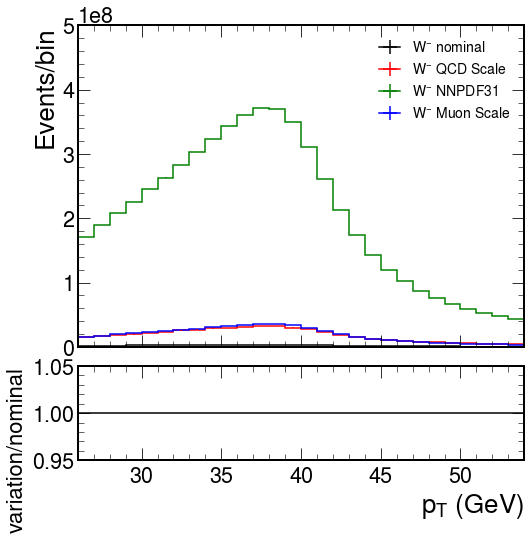

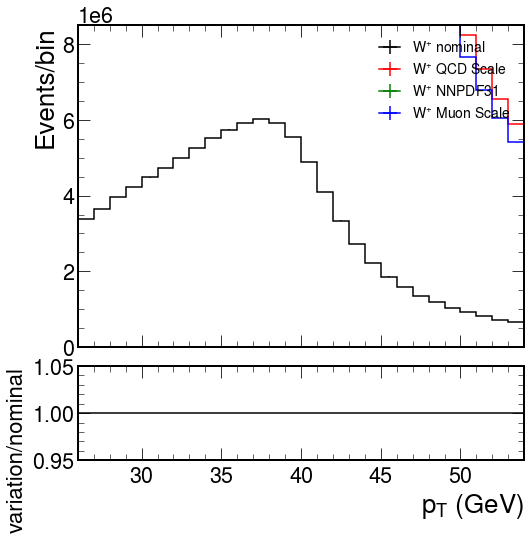

In [138]:
makeVariationPlot('WminusmunuPostVFP', variations, "pt", xlabel=r"p$_{T}$ (GeV)", rrange=[0.95, 1.05], scale=5e8)
makeVariationPlot('WplusmunuPostVFP', variations, "pt", xlabel=r"p$_{T}$ (GeV)", rrange=[0.95, 1.05])
